In [1]:
from model import *
from data2 import *
from nets.MaxPoolingWithIndices2D import MaxPoolingWithIndices2D
from nets.MaxUnpoolingWithIndices2D import MaxUnpoolingWithIndices2D

In [2]:
img_rows = 256
img_cols = 256
smooth = 1.
class AdaptiveAvgPool2D(Layer):  
    def __init__(self, output_size):    
        super(AdaptiveAvgPool2D, self).__init__()  
        self.output_size = np.array(output_size)      
        #print(output_size)
    def call(self, x):        
        input_size = [x.shape[1], x.shape[2]]
        stride = np.floor((input_size / self.output_size))  
        print(stride)
        kernel_size = x.shape[1:3] - (self.output_size - 1) * stride  
        #print(kernel_size)
        kernel_size = tuple(kernel_size)  
        print(x)
        out = tf.nn.avg_pool2d(x, ksize=kernel_size, strides=stride, padding='VALID')  
        out = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(out)
        return out
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
def aunet_r16(pretrained_weights = None,num_classes = 1,input_size = (256,256,3)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    #residual_block
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    #UNet_residual_down_block
    UNet_residual_down_block = MaxPooling2D(pool_size=(2, 2))(x)
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    
        #residual_block
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    UNet_residual_down_block = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block)
    UNet_residual_down_block = BatchNormalization()(UNet_residual_down_block)
    UNet_residual_down_block = layers.ReLU()(UNet_residual_down_block)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #residual_block128
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #UNet_residual_down_block128
    UNet_residual_down_block128 = MaxPooling2D(pool_size=(2, 2))(x)
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    
        #residual_block
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block128)
    UNet_residual_down_block128 = BatchNormalization()(UNet_residual_down_block128)
    UNet_residual_down_block128 = layers.ReLU()(UNet_residual_down_block128)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
           #residual_block256
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
            #UNet_residual_down_block256
    UNet_residual_down_block256 = MaxPooling2D(pool_size=(2, 2))(x)
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    
        #residual_block
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block256)
    UNet_residual_down_block256 = BatchNormalization()(UNet_residual_down_block256)
    UNet_residual_down_block256 = layers.ReLU()(UNet_residual_down_block256)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #residual_block128
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #UNet_residual_down_block512
    UNet_residual_down_block512 = MaxPooling2D(pool_size=(2, 2))(x)
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    
        #residual_block
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block512)
    UNet_residual_down_block512 = BatchNormalization()(UNet_residual_down_block512)
    UNet_residual_down_block512 = layers.ReLU()(UNet_residual_down_block512)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #residual_block1024
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #UNet_residual_down_block1024
    UNet_residual_down_block1024 = MaxPooling2D(pool_size=(2, 2))(x)
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    
        #residual_block
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_uniform')(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = BatchNormalization()(UNet_residual_down_block1024)
    UNet_residual_down_block1024 = layers.ReLU()(UNet_residual_down_block1024)
    
    x = ((UpSampling2D(size = (2,2))(x)))
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
        #residual_block128
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    #x = Add()([x, UNet_residual_down_block1024])
    x = AdaptiveAvgPool2D(1)(x)

    model = Model(inputs=[inputs], outputs=[x])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model

model = aunet_r16(None,1,(256,256,1))
model.summary()

[32. 32.]
Tensor("re_lu_65/Relu:0", shape=(None, 32, 32, 512), dtype=float32)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
__________________________________________

In [3]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm
from sklearn.metrics import plot_precision_recall_curve,confusion_matrix,precision_score,recall_score,f1_score,average_precision_score,PrecisionRecallDisplay
def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    from tensorflow.python.keras.metrics import Metric    
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)
    #print(sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]))
    return tn, fp, fn, tp
def plot_Micro_averaged_precision_recall_curve(groundtruth,predicted,threshold):    
    from tensorflow.python.keras.metrics import Metric
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    precision = dict()
    recall = dict()
    average_precision = dict()
    precision["micro"], recall["micro"], _ = precision_recall_curve(predicted_list.ravel(), groundtruth_list.ravel())
    average_precision["micro"] = average_precision_score(predicted_list, groundtruth_list, average="micro")
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],)
    display.plot()
    _ = display.ax_.set_title("Micro-averaged over all classes")
    
    return precision,recall


def plot_precision_recall_curve(groundtruth,predicted,threshold):    
    from tensorflow.python.keras.metrics import Metric
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    #threshold = 0.1
    #y_pred_mod = (predicted_list > threshold).astype(int)
    #print(y_pred_mod)
    display = PrecisionRecallDisplay.from_predictions(predicted_list, groundtruth_list, name="LinearSVC")
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    precisions, recalls, thresholds = precision_recall_curve(groundtruth_list,predicted_list)
    #print(precisions)
    #plot_precision_recall_curve(Unet(),groundtruth_list,predicted_list)
    #plt.show
    #plt.savefig('fuckmu.png')
    
    return precisions,recalls
def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list,threshold):

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    sensitivity =tn / (tn+fp)
    #if(tp == nan and fp == 0):
    #    prec =0
    #print("tp: ",tp)
    #print("fp: ",fp)
#    if ( prec >= threshold ) :
#        tp = tp + fn 
#        fn = 1
#        prec=tp/(tp+fp)
#        rec=tp/(tp+fn)
#    else :
#        fn = tp + fn
#        tp = 1
#        prec=tp/(tp+fp)
#        rec=tp/(tp+fn)

    if np.isnan(rec) == True :
        rec = 0
    if np.isnan(prec) == True :
        prec = 0
    #accuracy = tp
    #prec=tn
    #rec=fp
    #IoU=tp
    return prec,rec,IoU,accuracy,sensitivity





def evalResult(gth_path,npyfile,target_size=(512,512),threshold=0.5,lag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(type(files))
    #files = [(int(x) for x in files)]
    #files.sort()
    #files = [(str(x) for x in files)]
    #sorted([int(x) for  in files])
    #files = [str(x) for x in files]
    #files.sorted(files)
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    sensitivity=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        #print("hhh : ",list(enumerate(npyfile)))
        #print("img: ",img)
        #print("gth: ",i)
        gth = trans.resize(gth,target_size)
        img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        gth1=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
        p,r,I,a,f,s=get_validation_metrics(gth1,img1,threshold)
        #plot_precision_recall_curve(gth1,img1,threshold)
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        sensitivity = sensitivity + s 
        f1_score=f1_score+f
        
    print("Precision=",prec/(i+1),"sensitivity= ", sensitivity/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))  

def get_f1_score(groundtruth_list, predicted_list):

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score
def get_validation_metrics(groundtruth,predicted,threshold):
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    #print(groundtruth_list)
    prec,rec,IoU,acc,sensitivity=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list,threshold)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
    print("Prec=",prec, "sensitivity=",sensitivity,"Recall=",rec, "IOU=",IoU, "acc=",acc, "F1=",f1_score)
    #print(f1_score)
    return prec,rec,IoU,acc,f1_score,sensitivity


KeyboardInterrupt: 

In [ ]:
def predict_at_threshold(prob, threshold):
    return np.where(prob >= threshold, 1., 0.)

def precision_at_threshold(Y, prob, threshold):
    Y_hat = predict_at_threshold(prob, threshold)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y_hat)

def recall_at_threshold(Y, prob, threshold):
    Y_hat = predict_at_threshold(prob, threshold)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y)

def precision_recall_curve(Y, prob):
    unique_thresh = np.unique(prob)
    precision = [precision_at_threshold(Y, prob, t) for t in unique_thresh]
    recall = [recall_at_threshold(Y, prob, t) for t in unique_thresh]
    return precision, recall, unique_thresh


#precision, recall, threshold = precision_recall_curve(Y,  lr_model.predict_proba(X)[:, 1])

### Train with npy file

In [19]:
img_rows = 256
img_cols = 256
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 
def get_wnet_fit(pretrained_weights = None,num_classes = 1,input_size = (256, 256, 1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model

In [ ]:
def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #binary_crossentropy
    #mean_squared_error
    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
def get_wnet666(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = aspp_block(pool4, 512)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
   
   
    ##################################

    conv1 = concatenate([Conv2D(32, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv9),conv9], axis = 3)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv2 = Conv2D(32, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv2 = concatenate([Conv2D(64, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(pool1),conv8], axis = 3)
    conv2 = Conv2D(64, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv3 = BatchNormalization()(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv3 = concatenate([Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2),conv7], axis = 3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv4 = BatchNormalization()(conv4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv4 = concatenate([Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3),conv6], axis = 3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    ################
    conv10 = aspp_block(conv9, 32)
    
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv10)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    smooth = 1.
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def test(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)


    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))((conv5)))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)    # relu / sigmoid / tanh

    model = Model(inputs = inputs, outputs = conv10)

    #conv10 = Conv2D(1, 1)(conv9)
    
    #model = tf.keras.Model(inputs = inputs, outputs = conv10)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    smooth = 1.
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    #x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    #x2 = BatchNormalization()(x2)

    #x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    #x3 = BatchNormalization()(x3)

    #x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    #x4 = BatchNormalization()(x4)

    #y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def connect_unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = aspp_block(pool4, 2)


    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)
#
    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
#
    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv14)
    conv14 = BatchNormalization()(conv14)
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      
#
    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv18)
    conv18 = BatchNormalization()(conv18)
    conv18 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv18)
    conv18 = BatchNormalization()(conv18)
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    #model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])

    #model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #binary_crossentropy
    #mean_squared_error
    # model.summary()

    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    smooth = 1.
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def usnet4(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    #conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    #x = aspp_block(x, 32)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def connect_segnet(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = BatchNormalization()(conv5)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #conv5 = BatchNormalization()(conv5)
    conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = aspp_block(x, 32)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def usnet4_aspp(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = BatchNormalization()(conv5)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #conv5 = BatchNormalization()(conv5)
    conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = aspp_block(x, 32)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)


    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))((conv5)))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)    # relu / sigmoid / tanh

    model = Model(inputs = inputs, outputs = conv10)

    
    #binary_crossentropy
    #mean_squared_error
    # model.summary()


    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = ['accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def usnet4_aspp_1(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = BatchNormalization()(conv5)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #conv5 = BatchNormalization()(conv5)
    conv5 = aspp_block(pool4, 1024)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = aspp_block(x, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def sunet(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(x10)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    
    conv2 = layers.concatenate([conv2,x9], axis = 3)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 =  layers.concatenate([conv3,x8], axis = 3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 =  layers.concatenate([conv4,x7], axis = 3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = BatchNormalization()(conv5)
    #conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #conv5 = BatchNormalization()(conv5)
    conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
   
    conv9 = aspp_block(conv9, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(conv9)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = [dice_coef, iou_coef,'accuracy'])
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [28]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_correct(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):##這個
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)

   
    x10 = aspp_block(x10, 64)
    #xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation='sigmoid', kernel_initializer='he_uniform')(x10)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #xoutputs = Conv2D(1, 1, activation = 'sigmoid')(xoutputs)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_correct222(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('tanh')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('tanh')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('tanh')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('tanh')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('tanh')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('tanh')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('tanh')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('tanh')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('tanh')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('tanh')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('tanh')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('tanh')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('tanh')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('tanh')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('tanh')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('tanh')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('tanh')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('tanh')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('tanh')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('tanh')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('tanh')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('tanh')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('tanh')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('tanh')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('tanh')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('tanh')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('tanh')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('tanh')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('tanh')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('tanh')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('tanh')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('tanh')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('tanh')(x10)
    
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = SGD(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
img_rows = 256
img_cols = 256
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 
def ssnet_correct_look(pretrained_weights = None,num_classes = 1,input_size = (256, 256, 1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)

    
    x4 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)  

    
    # decoder

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_4])
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)

    
    
    
    # decoder

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_4])
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)


    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)


    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = layers.Convolution2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    

    model = Model(inputs=[inputs], outputs=[xoutputs])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model




In [ ]:
img_rows = 256
img_cols = 256
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 
def ssnet_correct_look2(pretrained_weights = None,num_classes = 1,input_size = (256, 256, 1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 256)
    up6 = concatenate([MaxUnpoolingWithIndices2D((2, 2))([conv5, mask_4]), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([MaxUnpoolingWithIndices2D((2, 2))([conv6, mask_3]), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([MaxUnpoolingWithIndices2D((2, 2))([conv7, mask_2]), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([MaxUnpoolingWithIndices2D((2, 2))([conv8, mask_1]), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10, mask_10 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv10)
   

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11, mask_11 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12, mask_12 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13, mask_13 = MaxPoolingWithIndices2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_try(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_try2(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_try3(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])

   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_try3(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def ssnet2(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 128)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def ssnet3(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = aspp_block(x5, 512)
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    x5_1 = aspp_block(x5_1, 512)
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def ssnet4(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    x10 = aspp_block(x10, 128)
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2_1 = layers.BatchNormalization()(x2)
    x2_1 = layers.Activation('relu')(x2)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 128)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(3 * rate_scale, 3 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(x1)
    return y 
def ssnet_skipconnect(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x_temp = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_temp)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2_temp = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_temp)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3_temp = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_temp)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4_temp = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_temp)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5_temp = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_temp)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.concatenate([x5_temp,x6], axis = 3)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.concatenate([x4_temp,x7], axis = 3)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.concatenate([x3_temp,x8], axis = 3)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.concatenate([x2_temp,x9], axis = 3)
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.concatenate([x_temp,x10], axis = 3)
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1_temp = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1_temp)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1_temp = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1_temp)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1_temp = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1_temp)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1_temp = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1_temp)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1_temp = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1_temp)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.concatenate([x5_1_temp,x6], axis = 3)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.concatenate([x4_1_temp,x7], axis = 3)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.concatenate([x3_1_temp,x8], axis = 3)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.concatenate([x2_1_temp,x9], axis = 3)
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    x10 = layers.concatenate([x_1_temp,x10], axis = 3)
    x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x10 = layers.BatchNormalization()(x10)
    x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def ssnet_skipconnect2(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x_temp = layers.Activation('relu')(x)    
    x2, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_temp)
    
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2_temp = layers.Activation('relu')(x2)    
    x3, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_temp)
    
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3_temp = layers.Activation('relu')(x3)
    x4, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_temp)
    x4 = layers.Dropout(0.5)(x4)
    
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4_temp = layers.Activation('relu')(x4)
    x5, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_temp)
    x5 = layers.Dropout(0.5)(x5)
    
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5_temp = layers.Activation('relu')(x5)
    x5, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_temp)
    x5 = layers.Dropout(0.5)(x5)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5, mask_5])
    x6 = layers.concatenate([x5_temp,x6], axis = 3)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.concatenate([x4_temp,x7], axis = 3)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.concatenate([x3_temp,x8], axis = 3)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.concatenate([x2_temp,x9], axis = 3)
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    #x10 = layers.concatenate([x_temp,x10], axis = 3)
    #x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    #x10 = layers.BatchNormalization()(x10)
    #x10 = layers.Activation('relu')(x10)
    
    #newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    x_1 = layers.BatchNormalization()(x_1)
    x_1 = layers.Activation('relu')(x_1)
    x_1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x_1)
    x_1 = layers.BatchNormalization()(x_1)
    x_1_temp = layers.Activation('relu')(x_1)    
    x2_1, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x_1_temp)
    
    merge2 = layers.concatenate([x2_1,x9], axis = 3)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(merge2)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1 = layers.Activation('relu')(x2_1)
    x2_1 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x2_1)
    x2_1 = layers.BatchNormalization()(x2_1)
    x2_1_temp = layers.Activation('relu')(x2_1)    
    x3_1, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x2_1_temp)
    
    merge3 = layers.concatenate([x3_1,x8], axis = 3)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(merge3)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1 = layers.Activation('relu')(x3_1)
    x3_1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x3_1)
    x3_1 = layers.BatchNormalization()(x3_1)
    x3_1_temp = layers.Activation('relu')(x3_1)
    x4_1, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x3_1_temp)
    x4_1 = layers.Dropout(0.5)(x4_1)
    
    merge4 = layers.concatenate([x4_1,x7], axis = 3)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge4)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1 = layers.Activation('relu')(x4_1)
    x4_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x4_1)
    x4_1 = layers.BatchNormalization()(x4_1)
    x4_1_temp = layers.Activation('relu')(x4_1)
    x5_1, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x4_1_temp)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    merge5 = layers.concatenate([x5_1,x6], axis = 3)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(merge5)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1 = layers.Activation('relu')(x5_1)
    x5_1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x5_1)
    x5_1 = layers.BatchNormalization()(x5_1)
    x5_1_temp = layers.Activation('relu')(x5_1)
    x5_1, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x5_1_temp)
    x5_1 = layers.Dropout(0.5)(x5_1)
    
    # decoder
    x6 = MaxUnpoolingWithIndices2D((2, 2))([x5_1, mask_5])
    x6 = layers.concatenate([x5_1_temp,x6], axis = 3)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x6)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Activation('relu')(x6)
    x6 = layers.Dropout(0.5)(x6)

    x7 = MaxUnpoolingWithIndices2D((2, 2))([x6, mask_4])
    x7 = layers.concatenate([x4_1_temp,x7], axis = 3)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x7)
    x7 = layers.BatchNormalization()(x7)
    x7 = layers.Activation('relu')(x7)
    x7 = layers.Dropout(0.5)(x7)

    x8 = MaxUnpoolingWithIndices2D((2, 2))([x7, mask_3])
    x8 = layers.concatenate([x3_1_temp,x8], axis = 3)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x8)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.Activation('relu')(x8)
    x8 = layers.Dropout(0.5)(x8)

    x9 = MaxUnpoolingWithIndices2D((2, 2))([x8, mask_2])
    x9 = layers.concatenate([x2_1_temp,x9], axis = 3)
    x9 = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)
    x9 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x9)
    x9 = layers.BatchNormalization()(x9)
    x9 = layers.Activation('relu')(x9)

    x10 = MaxUnpoolingWithIndices2D((2, 2))([x9, mask_1])
    #x10 = layers.concatenate([x_1_temp,x10], axis = 3)
    #x10 = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x10)
    #x10 = layers.BatchNormalization()(x10)
    #x10 = layers.Activation('relu')(x10)
    
   
    x10 = aspp_block(x10, 64)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x10)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [connectloss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [ ]:
def expend_as(tensor, rep):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat


def AttnGatingBlock(x, g, inter_shape):
	shape_x = K.int_shape(x)  # 32
	shape_g = K.int_shape(g)  # 16
	theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
	shape_theta_x = K.int_shape(theta_x)
	phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
	upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)  # 16
	concat_xg = add([upsample_g, theta_x])
	act_xg = Activation('relu')(concat_xg)
	psi = Conv2D(1, (1, 1), padding='same')(act_xg)
	sigmoid_xg = Activation('sigmoid')(psi)
	shape_sigmoid = K.int_shape(sigmoid_xg)
	upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
	upsample_psi = expend_as(upsample_psi, shape_x[3])
	y = multiply([upsample_psi, x])
	result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
	result_bn = BatchNormalization()(result) 
	return result_bn

def UnetGatingSignal(inputs, is_batchnorm=False):
    shape = K.int_shape(inputs)
    x = Conv2D(shape[3] * 2, (1, 1), strides=(1, 1), padding="same")(inputs)
    if is_batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def anet(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    gating = UnetGatingSignal(conv5, is_batchnorm=True)
    attn_1 = AttnGatingBlock(conv4, gating, 256)
    up6 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv5), attn_1], axis=3)  
    
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    gating = UnetGatingSignal(conv6, is_batchnorm=True)
    attn_2 = AttnGatingBlock(conv3, gating, 128)
    up7 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv6), attn_2], axis=3) 
    
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    gating = UnetGatingSignal(conv7, is_batchnorm=True)
    attn_3 = AttnGatingBlock(conv2, gating, 64)
    up8 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv7), attn_3], axis=3) 
    
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    gating = UnetGatingSignal(conv8, is_batchnorm=True)  
    attn_4 = AttnGatingBlock(conv1, gating, 32)
    up9 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv8), attn_4], axis=3) 
    
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    model.compile(optimizer=Adam(1e-4), loss=[connectloss], metrics=[dice_coef, iou_coef])
    return model

In [ ]:
def expend_as(tensor, rep):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat


def AttnGatingBlock(x, g, inter_shape):
	shape_x = K.int_shape(x)  # 32
	shape_g = K.int_shape(g)  # 16
	theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
	shape_theta_x = K.int_shape(theta_x)
	phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
	upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)  # 16
	concat_xg = add([upsample_g, theta_x])
	act_xg = Activation('relu')(concat_xg)
	psi = Conv2D(1, (1, 1), padding='same')(act_xg)
	sigmoid_xg = Activation('sigmoid')(psi)
	shape_sigmoid = K.int_shape(sigmoid_xg)
	upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
	upsample_psi = expend_as(upsample_psi, shape_x[3])
	y = multiply([upsample_psi, x])
	result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
	result_bn = BatchNormalization()(result) 
	return result_bn

def UnetGatingSignal(inputs, is_batchnorm=False):
    shape = K.int_shape(inputs)
    x = Conv2D(shape[3] * 2, (1, 1), strides=(1, 1), padding="same")(inputs)
    if is_batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def SegNet(pretrained_weights = None,num_classes = 1,input_size = (256,256,1)):
    inputs = layers.Input(shape=input_size)

    # encoder
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    outputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation='sigmoid', kernel_initializer='he_uniform')(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))
    model.compile(optimizer=Adam(1e-4), loss=[connectloss], metrics=[dice_coef, iou_coef])
    return model

In [62]:
imgs_train,imgs_mask_train = geneTrainNpy("D:/Alldata/hospital_inbreast/croponly/train/traincomb2/","D:/Alldata/hospital_inbreast/croponly/train/traincomb2/")

['D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_0.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_10.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_100.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1000.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1001.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1002.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1003.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1004.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1005.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1006.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1007.png', 'D:/Alldata/hospital_inbreast/croponly/train/traincomb2\\image_1008.png', 'D:/Alldata/hospital_inbreast/croponly/train/t

SyntaxError: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0) (<string>)

In [ ]:
imgs_train,imgs_mask_train = geneTrainNpy("D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256","D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256")

['D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_0.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_1.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_100.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_1000.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10000.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10001.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10002.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10003.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10004.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\\image_10005.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincomtight256\

In [5]:
img_rows = 256
img_cols = 256
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 
def get_wnet_fit_vgg16(pretrained_weights = None,num_classes = 1,input_size = (256, 256, 1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4_1)
    conv4_1 = BatchNormalization()(conv4)
    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4_1)
    conv4_1 = BatchNormalization()(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    #conv5 = aspp_block(pool4_1, 512)
    
    up6_1 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(pool4_1), conv4_1], axis=3)
    conv6_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = BatchNormalization()(conv6_1)
    conv6_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = BatchNormalization()(conv6_1)
    conv6_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = BatchNormalization()(conv6_1)
    
    up6 = concatenate([(conv6_1), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    #conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)
    #conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    #conv11 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv11)
    #conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13_1 = concatenate([Conv2D(512, (3, 3), activation='relu', padding='same')(pool12), conv6_1], axis=3)
    conv13_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(down13_1)
    conv13_1 = BatchNormalization()(conv13_1)
    conv13_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv13_1)  
    conv13_1 = BatchNormalization()(conv13_1)    
    #conv13_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv13_1)  
    #conv13_1 = BatchNormalization()(conv13_1) 
    pool13_1 = MaxPooling2D(pool_size=(2, 2))(conv13_1)
    
    down13 = concatenate([Conv2D(512, (3, 3), activation='relu', padding='same')(conv13_1), conv6], axis=3)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)  
    #conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv13)  
    #conv13 = BatchNormalization()(conv13) 
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15_1 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up15_1)
    conv15_1 = BatchNormalization()(conv15_1)    
    conv15_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv15_1)
    #conv15_1 = BatchNormalization()(conv15_1) 
    #conv15_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(convconv15_115)
    conv15_1 = BatchNormalization()(conv15_1) 
    
    up15 = concatenate([(conv15_1), conv13_1], axis=3)
    conv15 = Conv2D(512, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(256, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      


    up17 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(128, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(64, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model

In [16]:

    imgs_train,imgs_mask_train = geneTrainNpy("D:/Alldata/ddsm_hospital_inbreast/traincomb/","D:/Alldata/ddsm_hospital_inbreast/traincomb/")

['D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_0.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_10.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_100.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1000.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1001.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1002.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1003.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1004.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1005.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1006.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1007.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1008.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1009.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_101.png', 'D:/Alldata/ddsm_hospital_inbreast/traincomb\\image_1010.png', '

In [24]:
imgs_train,imgs_mask_train = geneTrainNpy("D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256/","D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256/")

['D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_0.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_1.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_100.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_1000.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10000.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10001.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10002.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10003.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10004.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/traincombloose256\\image_10005.png', 'D:/Alldata/ddsm_hospital_inbreast/croponly/train/trainc

In [63]:
import datetime
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
mycallback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
              tf.keras.callbacks.EarlyStopping(patience=20, monitor = 'val_loss'),
              ModelCheckpoint('ssnet_result.hdf5', monitor='val_loss',verbose=1, save_weights_only=True, save_best_only=True)]
#myGene = train2numpy(2,'data/membrane_hospital_aughand/train','image','label',data_gen_args1,save_to_dir = None)
#valdata_image,valdata_mask = valGenerator(2,'data/membrane_hospital_aughand/val','image','label',data_gen_args1)
#model = unet3("test_hope2.hdf5")
#model = usnet2(None,1,(512,512,1))
model = get_wnet_fit(None,1,(256,256,1))
#model = ssnet_correct(None,1,(256,256,1))
#model = get_wnet_fit_vgg16(None,1,(256,256,1))
model.summary()
history=model.fit(imgs_train, imgs_mask_train,batch_size=4,epochs=5000,verbose=1,validation_split=0.2, shuffle=True, callbacks=[mycallback])

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_870 (Conv2D)             (None, 256, 256, 32) 320         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_786 (BatchN (None, 256, 256, 32) 128         conv2d_870[0][0]                 
__________________________________________________________________________________________________
conv2d_871 (Conv2D)             (None, 256, 256, 32) 9248        batch_normalization_786[0][0]    
______________________________________________________________________________________

Epoch 1/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.8343 - dice_coef: 0.8877 - iou_coef: 0.7988- ETA: 2s - loss: -0.8339 - dice_coWARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0229s). Check your callbacks.

Epoch 00001: val_loss improved from inf to -0.85369, saving model to wnet_hospital_inbreast.hdf5
1001/1001 [==============================] - 100s 100ms/step - loss: -0.8343 - dice_coef: 0.8877 - iou_coef: 0.7988 - val_loss: -0.8537 - val_dice_coef: 0.9010 - val_iou_coef: 0.8215
Epoch 2/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.8592 - dice_coef: 0.9062 - iou_coef: 0.8279- ETA: 1s - loss: -0.8591 - dice_coef: 0.906
Epoch 00002: val_loss improved from -0.85369 to -0.86064, saving model to wnet_hospital_inbreast.hdf5
1001/1001 [==============================] - 100s 100ms/step - loss: -0.8592 - dice_coef: 0.9062 - iou_coef: 0.8279 - val_lo

1000/1001 [============================>.] - ETA: 0s - loss: -0.8934 - dice_coef: 0.9301 - iou_coef: 0.8690
Epoch 00019: val_loss did not improve from -0.87276
1001/1001 [==============================] - 100s 100ms/step - loss: -0.8934 - dice_coef: 0.9301 - iou_coef: 0.8690 - val_loss: -0.8607 - val_dice_coef: 0.9053 - val_iou_coef: 0.8294
Epoch 20/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.8953 - dice_coef: 0.9314 - iou_coef: 0.8712
Epoch 00020: val_loss did not improve from -0.87276
1001/1001 [==============================] - 100s 100ms/step - loss: -0.8953 - dice_coef: 0.9314 - iou_coef: 0.8711 - val_loss: -0.8373 - val_dice_coef: 0.8887 - val_iou_coef: 0.8022
Epoch 21/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.8976 - dice_coef: 0.9331 - iou_coef: 0.8740
Epoch 00021: val_loss did not improve from -0.87276
1001/1001 [==============================] - 100s 100ms/step - loss: -0.8976 - dice_coef: 0.9331 - iou_coef: 0.8740 - val_loss

Epoch 41/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.9249 - dice_coef: 0.9515 - iou_coef: 0.9071
Epoch 00041: val_loss did not improve from -0.88098
1001/1001 [==============================] - 100s 100ms/step - loss: -0.9249 - dice_coef: 0.9515 - iou_coef: 0.9071 - val_loss: -0.8506 - val_dice_coef: 0.8986 - val_iou_coef: 0.8183
Epoch 42/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.9262 - dice_coef: 0.9524 - iou_coef: 0.9087
Epoch 00042: val_loss did not improve from -0.88098
1001/1001 [==============================] - 100s 100ms/step - loss: -0.9262 - dice_coef: 0.9523 - iou_coef: 0.9086 - val_loss: -0.8590 - val_dice_coef: 0.9049 - val_iou_coef: 0.8280
Epoch 43/5000
1000/1001 [============================>.] - ETA: 0s - loss: -0.9270 - dice_coef: 0.9530 - iou_coef: 0.9097- ETA: 1s - loss: -0.9271 - dice_coef: 0.9530 - iou_c
Epoch 00043: val_loss did not improve from -0.88098
1001/1001 [==============================] - 100s 100ms/ste

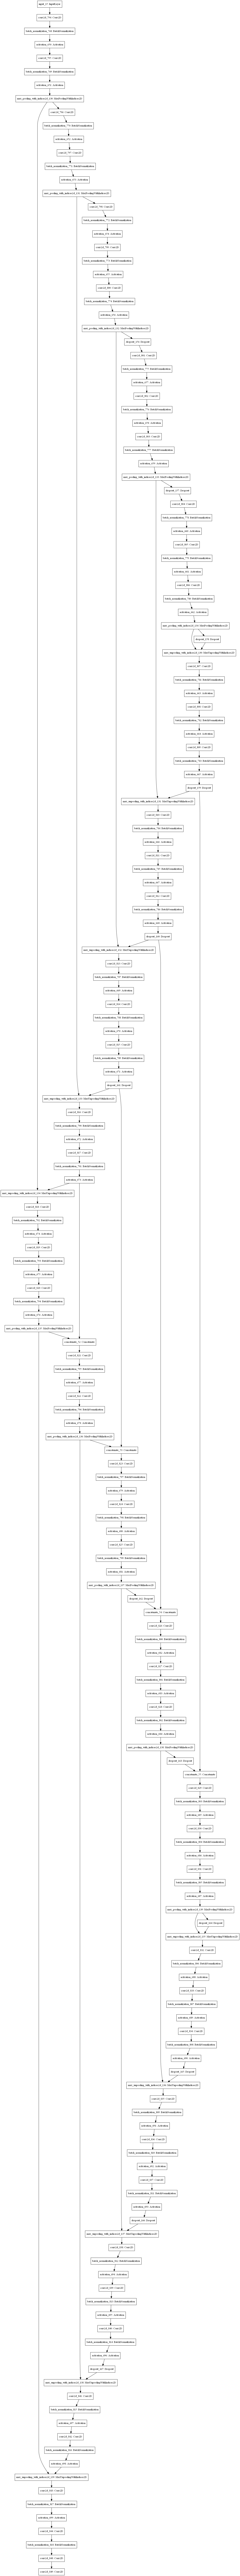

In [71]:
tf.keras.utils.plot_model(model, to_file='Model1.png')

In [56]:
model = anet(None,1,(256,256,1))
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_308 (Conv2D)             (None, 256, 256, 32) 320         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_291 (BatchN (None, 256, 256, 32) 128         conv2d_308[0][0]                 
__________________________________________________________________________________________________
conv2d_309 (Conv2D)             (None, 256, 256, 32) 9248        batch_normalization_291[0][0]    
______________________________________________________________________________________

In [95]:
testGene = testGenerator("data/membrane_hospital_aughand_fakeadd/test/tight256_clahe/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
model = get_wnet_fit()
#model.summary()
model.load_weights("wnent256_alldatatight_connectloss.hdf5")
#model.load_weights("un/et_fake.hdf5")

#model.load_weights("C:/Users/414/Desktop/trainresult/1205.hdf5")

results = model.predict_generator(testGene,48,verbose=1)
saveResult("data/membrane_hospital_aughand_fakeadd/test/pred/",results)

48/48 [==============================] - 1s 13ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [ ]:
from tensorflow.keras.utils import plot_model
model = ssnet(None,1,(256,256,1))
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [39]:
model = get_wnet_fit()
#model.summary()
model.load_weights("wnet_inbreast_ddsm.hdf5")
#print(results.shape)

['00.png', '01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png']
Precision= 0.8909051390956617 Recall= 0.9085379165757007 Sensitivity= 0.9085379165757007 Specificity= 0.8511665756295496 IoU= 0.817578936949421 acc= 0.8839969635009766 DSC= 0.899635135871045 F1= 0.8996351358710452


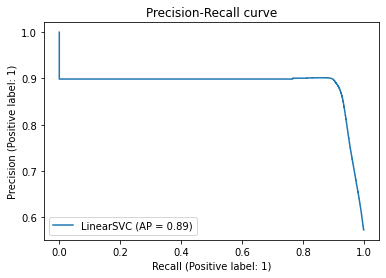

In [96]:
from sklearn.metrics import PrecisionRecallDisplay
#predicted_list ='data/membrane_hospital/test/pred_resize'
#groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_fakeadd/test/tight256labelpng/'


files=sorted(os.listdir(gt_path))
print(files)
intputshape = 256
gth1 = np.zeros((48,intputshape,intputshape)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(intputshape,intputshape))#512,512
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

175/175 [==============================] - 2s 10ms/step
['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png', '040.png', '041.png', '042.png', '043.png', '044.png', '045.png', '046.png', '047.png', '048.png', '049.png', '050.png', '051.png', '052.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '059.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '066.png', '067.png', '068.png', '069.png', '070.png', '071.png', '072.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '079.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png

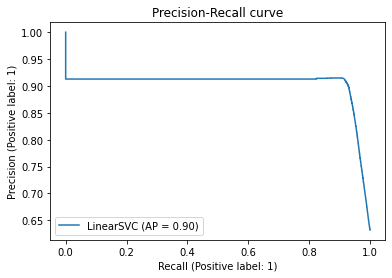

In [97]:
testGene = testGenerator("data/membrane_hospital_aughand_cropcomadd/test/tight256_clahe/")
results = model.predict_generator(testGene,175,verbose=1)
#saveResult("data/membrane_hospital_aughand_inbreast/test/pred/",results)
from sklearn.metrics import PrecisionRecallDisplay
# predicted_list ='data/membrane_hospital/test/pred_resize'
# groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_cropcomadd/test/tight256labelpng'


files=sorted(os.listdir(gt_path))
print(files)
intputshape = 256
gth1 = np.zeros((175,intputshape,intputshape)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(intputshape,intputshape))#512,512
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

110/110 [==============================] - 1s 10ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png', '040.png', '041.png', '042.png', '043.png', '044.png', '045.png', '046.png', '047.png', '048.png', '049.png', '050.png', '051.png', '052.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '059.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '066.png', '067.png', '068.png', '069.png', '070.png', '071.png', '072.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '079.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png', '086.png', '087.png', '088.png', '089.png', '090.png'

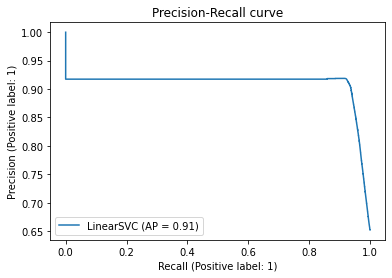

In [98]:
testGene = testGenerator("data/membrane_hospital_aughand_ddsm/test/tight256_clahe/")

results = model.predict_generator(testGene,110,verbose=1)
saveResult("data/membrane_hospital_aughand_ddsm/test/pred/",results)
from sklearn.metrics import PrecisionRecallDisplay
# predicted_list ='data/membrane_hospital/test/pred_resize'
# groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_ddsm/test/tight256labelpng'


files=sorted(os.listdir(gt_path))
print(files)
intputshape = 256
gth1 = np.zeros((110,intputshape,intputshape)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(intputshape,intputshape))#512,512
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

17/17 [==============================] - 0s 19ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

['00.png', '01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png']
Precision= 0.9435465103979352 Recall= 0.9382468024234265 Sensitivity= 0.9382468024234265 Specificity= 0.8792315351194786 IoU= 0.8883765399515979 acc= 0.9195197610294118 DSC= 0.9408891936079321 F1= 0.9408891936079321


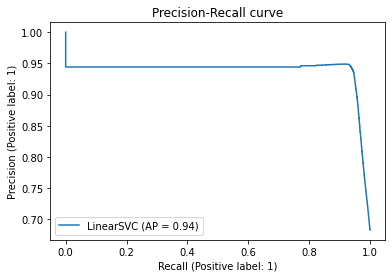

In [99]:
testGene = testGenerator("data/membrane_hospital_aughand_inbreast/test/tight256_clahe/")

results = model.predict_generator(testGene,17,verbose=1)
saveResult("data/membrane_hospital_aughand_inbreast/test/pred/",results)
from sklearn.metrics import PrecisionRecallDisplay
# predicted_list ='data/membrane_hospital/test/pred_resize'
# groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_inbreast/test/tight256labelpng'


files=sorted(os.listdir(gt_path))
print(files)
intputshape = 256
gth1 = np.zeros((17,intputshape,intputshape)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(intputshape,intputshape))#512,512
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

In [66]:
testGene = testGenerator("data/mineclahetrain1/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain1/pred/",results)
testGene = testGenerator("data/mineclahetrain2/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain2/pred/",results)
testGene = testGenerator("data/mineclahetrain3/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain3/pred/",results)
testGene = testGenerator("data/mineclahetrain4/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain4/pred/",results)
testGene = testGenerator("data/mineclahetrain5/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,460,verbose=1)
saveResult("data/mineclahetrain5/pred/",results)
testGene = testGenerator("data/mineclahetrain6/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain6/pred/",results)
testGene = testGenerator("data/mineclahetrain7/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain7/pred/",results)
testGene = testGenerator("data/mineclahetrain8/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain8/pred/",results)
testGene = testGenerator("data/mineclahetrain9/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain9/pred/",results)
testGene = testGenerator("data/mineclahetrain10/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,500,verbose=1)
saveResult("data/mineclahetrain10/pred/",results)
testGene = testGenerator("data/mineclahetrain11/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
results = model.predict_generator(testGene,304,verbose=1)
saveResult("data/mineclahetrain11/pred/",results)

 75/500 [===>..........................] - ETA: 11s

KeyboardInterrupt: 

In [37]:
import datetime
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
mycallback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
              tf.keras.callbacks.EarlyStopping(patience=20, monitor = 'val_loss'),
              ModelCheckpoint('wnettruefit_test_newlossfkkkk.hdf5', monitor='val_loss',verbose=1, save_weights_only=True, save_best_only=True)]
#myGene = train2numpy(2,'data/membrane_hospital_aughand/train','image','label',data_gen_args1,save_to_dir = None)
#valdata_image,valdata_mask = valGenerator(2,'data/membrane_hospital_aughand/val','image','label',data_gen_args1)
#model = unet3("test_hope2.hdf5")
#model = usnet2(None,1,(512,512,1))
#model = get_wnet_fit(None,1,(256,256,1))
model = test(None,1,(256,256,1))
model.summary()
history=model.fit(imgs_train, imgs_mask_train,batch_size=2,epochs=5000,verbose=1,validation_split=0.2, shuffle=True, callbacks=[mycallback])

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_424 (Conv2D)             (None, 256, 256, 64) 640         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_299 (BatchN (None, 256, 256, 64) 256         conv2d_424[0][0]                 
__________________________________________________________________________________________________
conv2d_425 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_299[0][0]    
______________________________________________________________________________________

Epoch 1/5000


KeyboardInterrupt: 

In [35]:
model1 = get_wnet()
model1.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_860 (Conv2D)             (None, 256, 256, 32) 896         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_670 (BatchN (None, 256, 256, 32) 128         conv2d_860[0][0]                 
__________________________________________________________________________________________________
conv2d_861 (Conv2D)             (None, 256, 256, 32) 9248        batch_normalization_670[0][0]    
______________________________________________________________________________________

In [34]:
img_rows = 256
img_cols = 256
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def get_wnet():
    inputs = Input((256, 256, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(down10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(down11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)   
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(down12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv12)    
    conv12 = BatchNormalization()(conv12)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(down13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv13)  
    conv13 = BatchNormalization()(conv13)    
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(up15)
    conv15 = BatchNormalization()(conv15)    
    conv15 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv15)
    conv15 = BatchNormalization()(conv15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(up16)
    conv16 = BatchNormalization()(conv16)     
    conv16 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv16)
    conv16 = BatchNormalization()(conv16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(up17)
    conv17 = BatchNormalization()(conv17)      
    conv17 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv17)
    conv17 = BatchNormalization()(conv17)  
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up18)
    conv18 = BatchNormalization()(conv18)      
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv18)
    conv18 = BatchNormalization()(conv18)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(1e-4), loss=[loss], metrics=[dice_coef, iou_coef])
    return model

name = 'mydata'


In [50]:
imgs_train,imgs_mask_train = geneTrainNpy("D:/Alldata/inbreast_ddsm/croponly/train/traincomb3/","D:/Alldata/inbreast_ddsm/croponly/train/traincomb3/")
#imgs_train,imgs_mask_train = valGenerator(2,'data/membrane_hospital_aughand/train','image','label',data_gen_args)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
mycallback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
              tf.keras.callbacks.EarlyStopping(patience=20, monitor = 'val_loss'),
              ModelCheckpoint('wnettruefit_testcrop_newlossfkkkk.hdf5', monitor='val_loss',verbose=1, save_weights_only=True, save_best_only=True)]
#myGene = train2numpy(2,'data/membrane_hospital_aughand/train','image','label',data_gen_args1,save_to_dir = None)
#valdata_image,valdata_mask = valGenerator(2,'data/membrane_hospital_aughand/val','image','label',data_gen_args1)
#model = unet3("test_hope2.hdf5")
#model = usnet2(None,1,(512,512,1))
model = get_wnet_fit()
#model = unet()
history=model.fit(imgs_train, imgs_mask_train,batch_size=2,epochs=5000,verbose=1,validation_split=0.2, shuffle=True, callbacks=[mycallback])

['D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_0.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_10.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_100.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1000.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1001.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1002.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1003.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1004.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1005.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1006.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1007.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1008.png', 'D:/Alldata/inbreast_ddsm/croponly/train/traincomb3\\image_1009.png', 'D:/Alldata/inbreast_ddsm/cr

KeyboardInterrupt: 

### test your model and save predicted results

In [54]:
testGene = testGenerator("data/membrane_hospital_aughand_fakeadd/test/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
model = usnet4()
model.load_weights("usnet4_testcrop5_iouloss.hdf5")
#model.load_weights("un/et_fake.hdf5")

#model.load_weights("C:/Users/414/Desktop/trainresult/1205.hdf5")

results = model.predict_generator(testGene,48,verbose=1)
saveResult("data/membrane_hospital_aughand_fakeadd/test/pred/",results)

InvalidArgumentError:  padded_shape[0]=46 is not divisible by block_shape[0]=6
	 [[node functional_69/conv2d_1251/Conv2D/SpaceToBatchND (defined at \AppData\Local\Temp/ipykernel_15580/438085693.py:8) ]] [Op:__inference_predict_function_298323]

Function call stack:
predict_function


In [100]:
from sklearn.metrics import PrecisionRecallDisplay
# predicted_list ='data/membrane_hospital/test/pred_resize'
# groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_ddsm/test/labelpng'


files=sorted(os.listdir(gt_path))
print(files)

gth1 = np.zeros((110,512,512)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(512,512))
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png', '040.png', '041.png', '042.png', '043.png', '044.png', '045.png', '046.png', '047.png', '048.png', '049.png', '050.png', '051.png', '052.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '059.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '066.png', '067.png', '068.png', '069.png', '070.png', '071.png', '072.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '079.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png', '086.png', '087.png', '088.png', '089.png', '090.png'

ValueError: Found input variables with inconsistent numbers of samples: [28835840, 262144]

In [43]:
gt_path='data/membrane_hospital_aughand/test/labelpng'
evalResult(gt_path,results,target_size=(512,512))

C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid va

Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.8410224914550781 F1= 0.0
Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.61236572265625 F1= 0.0
Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.9861068725585938 F1= 0.0
Prec= 0.0014998125234345708 sensitivity= 0.9897322599053039 Recall= 0.0014347202295552368 IOU= 0.000733810310034856 acc= 0.9792213439941406 F1= 0.001466544454628781
Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.5351676940917969 F1= 0.0
Prec= 1.0 sensitivity= 1.0 Recall= 0.011522234253070978 IOU= 0.011522234253070978 acc= 0.4950408935546875 F1= 0.022781969318903278
Prec= 0.0 sensitivity= 0.9962148190235354 Recall= 0.0 IOU= 0.0 acc= 0.94976806640625 F1= 0.0


C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)


Prec= 0.0 sensitivity= 0.9996184127528015 Recall= 0.0 IOU= 0.0 acc= 0.9793243408203125 F1= 0.0
Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.2924041748046875 F1= 0.0
Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.13622283935546875 F1= 0.0


C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid va

Prec= 0.9349514563106797 sensitivity= 0.9983251884163031 Recall= 0.03771811291933494 IOU= 0.03761939176123601 acc= 0.6240921020507812 F1= 0.07251096511868682
Prec= 1.0 sensitivity= 1.0 Recall= 3.663406235117412e-05 IOU= 3.663406235117412e-05 acc= 0.6876220703125 F1= 7.326544069162575e-05
Prec= 0.0 sensitivity= 0.9998279110988737 Recall= 0.0 IOU= 0.0 acc= 0.8865280151367188 F1= 0.0


C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)


Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.8261566162109375 F1= 0.0
Prec= 0.0 sensitivity= 0.9752896632220229 Recall= 0.0 IOU= 0.0 acc= 0.6534385681152344 F1= 0.0
Prec= 0.0 sensitivity= 0.9986510553508138 Recall= 0.0 IOU= 0.0 acc= 0.8641738891601562 F1= 0.0
Prec= 0.0 sensitivity= 0.9970175632387054 Recall= 0.0 IOU= 0.0 acc= 0.9296493530273438 F1= 0.0
Prec= 0.0 sensitivity= 0.9999658005660006 Recall= 0.0 IOU= 0.0 acc= 0.8923110961914062 F1= 0.0
Prec= 1.0 sensitivity= 1.0 Recall= 0.0391603599609001 IOU= 0.0391603599609001 acc= 0.27256011962890625 F1= 0.07536923360389453
Prec= 1.0 sensitivity= 1.0 Recall= 0.0048513752415409285 IOU= 0.0048513752415409285 acc= 0.3536567687988281 F1= 0.009655906059490202
Prec= 0.026595744680851064 sensitivity= 0.9981423771481936 Recall= 0.0001535673700052213 IOU= 0.00015270905870136216 acc= 0.7502365112304688 F1= 0.0003053714844107857
Prec= 0.11764705882352941 sensitivity= 0.9999118999653474 Recall= 2.1766812141527814e-05 IOU= 2.1763259265707632e-0

C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:109: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
C:\Users\414\AppData\Local\Temp/ipykernel_12784/2758311241.py:53: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)


Prec= 0 sensitivity= 1.0 Recall= 0.0 IOU= 0.0 acc= 0.7400856018066406 F1= 0.0
Prec= 0.5487269534679543 sensitivity= 0.9975466447742102 Recall= 0.011874228175168615 IOU= 0.011759393403450676 acc= 0.7996368408203125 F1= 0.023245434596645218
Prec= 1.0 sensitivity= 1.0 Recall= 0.026344185381033856 IOU= 0.026344185381033856 acc= 0.37697601318359375 F1= 0.05133596654275093
Prec= 1.0 sensitivity= 1.0 Recall= 0.010024256629691204 IOU= 0.010024256629691204 acc= 0.30718994140625 F1= 0.01984953641240407
Precision= 0.345306275693404 sensitivity=  0.9980483302545571 Recall= 0.005904714340128196 IoU= 0.005861790455875424 acc= 0.682256571451823 F1= 0.011428035665052756


In [7]:
testGene = testGenerator("data/membrane_hospital_aughand_123/test/")
model = unet()
model.load_weights("test_hope2.hdf5")
results = model.predict_generator(testGene,221,verbose=1)
saveResult("data/membrane_hospital_aughand_123/test/pred/",results)
gt_path='data/membrane_hospital_aughand_123/test/labelpng'
evalResult(gt_path,results,target_size=(512,512),threshold=0.5)
#evalResult(gt_path,results)

221/221 [==============================] - 227s 1s/step


C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/4_predict.png is

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/38_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/39_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/40_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to u

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/64_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/65_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/66_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to u

C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/90_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/92_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/93_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to u

C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/117_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/118_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/119_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-maste

C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/144_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/145_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/146_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-maste

C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/170_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/171_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/172_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-maste

C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/198_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/199_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_123/test/pred/200_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-maste

['0.png', '1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', 

(0.01847120075437778, 0.0045448810827578515)

### 資料可視化

In [ ]:
import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './testjpg/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
for file_name in filename_list:
    original = Image.open('./testjpg/'+file_name)
    img_name_temp = file_name.split(".jpg")
    img_name_temp = img_name_temp[0] + '.png'
    original = original.convert("L")
    original.save('testpng1/'+img_name_temp)    

In [15]:
import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand_fake/test/pred/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:
    img_name_temp = file_name.split("_predict")
    orignal = Image.open('./data/membrane_hospital_aughand_fake/test/'+img_name_temp[0]+'.png')
    w = orignal.width
    h = orignal.height
    mask = Image.open('./data/membrane_hospital_aughand_fake/test/pred/'+file_name)
    mask_new = mask.resize((w,h))
    mask_new.save('./data/membrane_hospital_aughand_fake/test/pred_resize/'+img_name_temp[0]+'_predictmask_resize.png')

path： ./data/membrane_hospital_aughand_fake/test/pred/
directory： []
file1： ['0_predict.png', '10_predict.png', '11_predict.png', '12_predict.png', '13_predict.png', '14_predict.png', '15_predict.png', '16_predict.png', '17_predict.png', '18_predict.png', '19_predict.png', '1_predict.png', '20_predict.png', '21_predict.png', '22_predict.png', '23_predict.png', '24_predict.png', '25_predict.png', '26_predict.png', '27_predict.png', '28_predict.png', '29_predict.png', '2_predict.png', '3_predict.png', '4_predict.png', '5_predict.png', '6_predict.png', '7_predict.png', '8_predict.png', '9_predict.png']


In [16]:
import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand_fake/test/pred_resize/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:
    img_name_temp = file_name.split("_predict")
    original = Image.open('./data/membrane_hospital_aughand_fake/test/pred_resize/'+file_name)
    original = original.convert("RGBA")
    w = original.width
    h = original.height
    for i in range(0,w):
        for j in range(0,h):
            data = (original.getpixel((i,j)))#540,1215
            #print (data)
            if (data[0]>=128 and data[1]>=128 and data[2]>=128):
                original.putpixel((i,j),(0,128,255,100))
            else :
                original.putpixel((i,j),(255,255,255,0))
    original.save('./data/membrane_hospital_aughand_fake/test/temp/'+img_name_temp[0]+'_rgbapredictmask_resize.png')
    print('success'+img_name_temp[0])

path： ./data/membrane_hospital_aughand_fake/test/pred_resize/
directory： []
file1： ['0_predictmask_resize.png', '10_predictmask_resize.png', '11_predictmask_resize.png', '12_predictmask_resize.png', '13_predictmask_resize.png', '14_predictmask_resize.png', '15_predictmask_resize.png', '16_predictmask_resize.png', '17_predictmask_resize.png', '18_predictmask_resize.png', '19_predictmask_resize.png', '1_predictmask_resize.png', '20_predictmask_resize.png', '21_predictmask_resize.png', '22_predictmask_resize.png', '23_predictmask_resize.png', '24_predictmask_resize.png', '25_predictmask_resize.png', '26_predictmask_resize.png', '27_predictmask_resize.png', '28_predictmask_resize.png', '29_predictmask_resize.png', '2_predictmask_resize.png', '3_predictmask_resize.png', '4_predictmask_resize.png', '5_predictmask_resize.png', '6_predictmask_resize.png', '7_predictmask_resize.png', '8_predictmask_resize.png', '9_predictmask_resize.png']
success0
success10
success11
success12
success13
success

In [23]:
import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand_fake/test/pred_resize/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:    
    img_name_temp = file_name.split("_predict")
    imagea = Image.open('./data/membrane_hospital_aughand_fake/test/'+img_name_temp[0]+'.png')
    imageb = Image.open('./data/membrane_hospital_aughand_fake/test/temp/'+img_name_temp[0]+'_rgbapredictmask_resize.png')
    imagec = Image.open('./data/membrane_hospital_aughand_fake/test/labeltemp/'+img_name_temp[0]+'_rgba_gt.png')
    newimageb = imageb
    imagea = imagea.convert("RGBA")
    #resultimage = Image.new('RGBA',imagea.size,(0,0,0,0))
    resultimage = imagea
    #resultimage.paste(imagea,(0,0))
    resultimage.paste(newimageb,(0,0),newimageb)
    resultimage.paste(imagec,(0,0),imagec)
    resultimage.save('./data/membrane_hospital_aughand_fake/test/visualresult/'+img_name_temp[0]+'_combinepredictmask.png')

path： ./data/membrane_hospital_aughand_fake/test/pred_resize/
directory： []
file1： ['0_predictmask_resize.png', '10_predictmask_resize.png', '11_predictmask_resize.png', '12_predictmask_resize.png', '13_predictmask_resize.png', '14_predictmask_resize.png', '15_predictmask_resize.png', '16_predictmask_resize.png', '17_predictmask_resize.png', '18_predictmask_resize.png', '19_predictmask_resize.png', '1_predictmask_resize.png', '20_predictmask_resize.png', '21_predictmask_resize.png', '22_predictmask_resize.png', '23_predictmask_resize.png', '24_predictmask_resize.png', '25_predictmask_resize.png', '26_predictmask_resize.png', '27_predictmask_resize.png', '28_predictmask_resize.png', '29_predictmask_resize.png', '2_predictmask_resize.png', '3_predictmask_resize.png', '4_predictmask_resize.png', '5_predictmask_resize.png', '6_predictmask_resize.png', '7_predictmask_resize.png', '8_predictmask_resize.png', '9_predictmask_resize.png']


## 轉groundtruth

In [17]:
# import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand_fake/test/labelpng/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    

for file_name in filename_list:
    img_name_temp = file_name.split(".png")
    original = Image.open('./data/membrane_hospital_aughand_fake/test/labelpng/'+file_name)
    print(file_name)
    original = original.convert("RGBA")
    w = original.width
    h = original.height
    for i in range(0,w):
        for j in range(0,h):
            data = (original.getpixel((i,j)))#540,1215
            #print (data)
            if (data[0]==255 and data[1]==255 and data[2]==255):
                original.putpixel((i,j),(255,0,0,100))
            else :
                original.putpixel((i,j),(255,255,255,0))
    original.save('./data/membrane_hospital_aughand_fake/test/labeltemp/'+img_name_temp[0]+'_rgba_gt.png')
    print('success'+img_name_temp[0])

path： ./data/membrane_hospital_aughand_fake/test/labelpng/
directory： []
file1： ['00.png', '01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png']
00.png
success00
01.png
success01
02.png
success02
03.png
success03
04.png
success04
05.png
success05
06.png
success06
07.png
success07
08.png
success08
09.png
success09
10.png
success10
11.png
success11
12.png
success12
13.png
success13
14.png
success14
15.png
success15
16.png
success16
17.png
success17
18.png
success18
19.png
success19
20.png
success20
21.png
success21
22.png
success22
23.png
success23
24.png
success24
25.png
success25
26.png
success26
27.png
success27
28.png
success28
29.png
success29


In [ ]:
import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand_fake/test/label/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
for file_name in filename_list:
    img_name_temp = file_name.split(".jpg")
    original = Image.open('./data/membrane_hospital_aughand_fake/test/label/'+file_name)
    print(file_name)
    original = original.convert("L")
    original.save('./data/membrane_hospital_aughand_fake/test/labelpng/'+img_name_temp[0]+'.png')
    print('success'+img_name_temp[0])

# 資料增強(垂直翻轉+90度旋轉)

## 單張處理

In [ ]:
#from PIL import Image
#
#img = Image.open("C:/Users/414/Desktop/unet-master/data/membrane_hospital/train/image/1.jpg")
#mask = Image.open("C:/Users/414/Desktop/unet-master/data/membrane_hospital/train/label/1.jpg")
##img.show()
#newnew_img=img.transpose(Image.ROTATE_180) 
#newnew_mask=mask.transpose(Image.ROTATE_180) 
#new_img = img.transpose(Image.FLIP_LEFT_RIGHT) 
#new_mask = mask.transpose(Image.FLIP_LEFT_RIGHT) 
##new_img.show()
#new_img.save("C:/Users/414/Desktop/unet-master/data/membrane_hospital/aughand/1-rotate.jpg")
#newnew_img.save("C:/Users/414/Desktop/unet-master/data/membrane_hospital/aughand/1-rotate_1.jpg")
#new_mask.save("C:/Users/414/Desktop/unet-master/data/membrane_hospital/aughand/1_mask-rotate.jpg")
#newnew_mask.save("C:/Users/414/Desktop/unet-master/data/membrane_hospital/aughand/1_mask-rotate_1.jpg")

## 批量處理 

In [ ]:
# import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/train/image/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
filename_list    
for file_name in filename_list:
    img_name_temp = file_name.split(".jpg")
    original_img = Image.open('./data/membrane_hospital/train/image/'+file_name)
    original_mask = Image.open('./data/membrane_hospital/train/label/'+img_name_temp[0]+".jpg")
    #print(file_name)
    new_img_90=original_img.transpose(Image.ROTATE_90) 
    new_mask_90 = original_mask.transpose(Image.ROTATE_90) 
    new_img_180=original_img.transpose(Image.ROTATE_180) 
    new_mask_180 = original_mask.transpose(Image.ROTATE_180) 
    new_img_270=original_img.transpose(Image.ROTATE_270) 
    new_mask_270 = original_mask.transpose(Image.ROTATE_270) 
    original_img.save('./data/membrane_hospital/train/aughand/image_beforeflip/'+img_name_temp[0]+'.jpg')
    original_mask.save('./data/membrane_hospital/train/aughand/label_beforeflip/'+img_name_temp[0]+'.jpg')
    
    new_img_90.save('./data/membrane_hospital/train/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_90.jpg')
    new_mask_90.save('./data/membrane_hospital/train/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_90.jpg')
    new_img_180.save('./data/membrane_hospital/train/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_180.jpg')
    new_mask_180.save('./data/membrane_hospital/train/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_180.jpg')
    new_img_270.save('./data/membrane_hospital/train/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_270.jpg')
    new_mask_270.save('./data/membrane_hospital/train/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_270.jpg')
    print('success'+img_name_temp[0])    

In [ ]:
# import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/train/aughand/image_beforeflip/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:
    img_name_temp = file_name.split(".jpg")
    original_img = Image.open('./data/membrane_hospital/train/aughand/image_beforeflip/'+file_name)
    original_mask = Image.open('./data/membrane_hospital/train/aughand/label_beforeflip/'+file_name)
    #print(file_name)
    new_img=original_img.transpose(Image.FLIP_LEFT_RIGHT) 
    new_mask= original_mask.transpose(Image.FLIP_LEFT_RIGHT) 
    
    original_img.save('./data/membrane_hospital/train/aughand/image/'+img_name_temp[0]+'.jpg')
    original_mask.save('./data/membrane_hospital/train/aughand/label/'+img_name_temp[0]+'.jpg')
    new_img.save('./data/membrane_hospital/train/aughand/image/'+img_name_temp[0]+'_flip.jpg')
    new_mask.save('./data/membrane_hospital/train/aughand/label/'+img_name_temp[0]+'_flip.jpg')
    print('success'+img_name_temp[0])    

In [ ]:
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/train/aughand/image/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files

i=0

for file_name in filename_list:
    img_name_temp = str(i)+".jpg"
    file_oldname_image = os.path.join("./data/membrane_hospital/train/aughand/image/", file_name)
    file_newname_image = os.path.join("./data/membrane_hospital/train/aughand/image/", img_name_temp)
    
    os.rename(file_oldname_image, file_newname_image)
    file_oldname_mask = os.path.join("./data/membrane_hospital/train/aughand/label/", file_name)
    file_newname_mask = os.path.join("./data/membrane_hospital/train/aughand/label/", img_name_temp)
    os.rename(file_oldname_mask, file_newname_mask)
    i=i+1

In [ ]:
# import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/val/image/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
filename_list    
for file_name in filename_list:
    img_name_temp = file_name.split(".jpg")
    original_img = Image.open('./data/membrane_hospital/val/image/'+file_name)
    original_mask = Image.open('./data/membrane_hospital/val/label/'+img_name_temp[0]+".jpg")
    #print(file_name)
    new_img_90=original_img.transpose(Image.ROTATE_90) 
    new_mask_90 = original_mask.transpose(Image.ROTATE_90) 
    new_img_180=original_img.transpose(Image.ROTATE_180) 
    new_mask_180 = original_mask.transpose(Image.ROTATE_180) 
    new_img_270=original_img.transpose(Image.ROTATE_270) 
    new_mask_270 = original_mask.transpose(Image.ROTATE_270) 
    original_img.save('./data/membrane_hospital/val/aughand/image_beforeflip/'+img_name_temp[0]+'.jpg')
    original_mask.save('./data/membrane_hospital/val/aughand/label_beforeflip/'+img_name_temp[0]+'.jpg')
    
    new_img_90.save('./data/membrane_hospital/val/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_90.jpg')
    new_mask_90.save('./data/membrane_hospital/val/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_90.jpg')
    new_img_180.save('./data/membrane_hospital/val/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_180.jpg')
    new_mask_180.save('./data/membrane_hospital/val/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_180.jpg')
    new_img_270.save('./data/membrane_hospital/val/aughand/image_beforeflip/'+img_name_temp[0]+'_rotate_270.jpg')
    new_mask_270.save('./data/membrane_hospital/val/aughand/label_beforeflip/'+img_name_temp[0]+'_rotate_270.jpg')
    print('success'+img_name_temp[0])    

In [ ]:
# import os
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/val/aughand/image_beforeflip/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:
    img_name_temp = file_name.split(".jpg")
    original_img = Image.open('./data/membrane_hospital/val/aughand/image_beforeflip/'+file_name)
    original_mask = Image.open('./data/membrane_hospital/val/aughand/label_beforeflip/'+file_name)
    #print(file_name)
    new_img=original_img.transpose(Image.FLIP_LEFT_RIGHT) 
    new_mask= original_mask.transpose(Image.FLIP_LEFT_RIGHT) 
    original_img.save('./data/membrane_hospital/val/aughand/image/'+img_name_temp[0]+'.jpg')
    original_mask.save('./data/membrane_hospital/val/aughand/label/'+img_name_temp[0]+'.jpg')
    new_img.save('./data/membrane_hospital/val/aughand/image/'+img_name_temp[0]+'_flip.jpg')
    new_mask.save('./data/membrane_hospital/val/aughand/label/'+img_name_temp[0]+'_flip.jpg')
    print('success'+img_name_temp[0])    

In [ ]:
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital/val/aughand/image/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files

i=1000

for file_name in filename_list:
    img_name_temp = str(i)+".jpg"
    file_oldname_image = os.path.join("./data/membrane_hospital/val/aughand/image/", file_name)
    file_newname_image = os.path.join("./data/membrane_hospital/val/aughand/image/", img_name_temp)
    
    os.rename(file_oldname_image, file_newname_image)
    file_oldname_mask = os.path.join("./data/membrane_hospital/val/aughand/label/", file_name)
    file_newname_mask = os.path.join("./data/membrane_hospital/val/aughand/label/", img_name_temp)
    os.rename(file_oldname_mask, file_newname_mask)
    i=i+1

轉uint8

In [ ]:
from PIL import Image, ImageDraw, ImageChops
yourPath = './data/membrane_hospital_aughand/train/aug_resize/'
allList = os.walk(yourPath)
for root, dirs, files in allList:
    print("path：", root)#   列出目前讀取到的路徑
    print("directory：", dirs)#   列出在這個路徑下讀取到的資料夾(第一層讀完才會讀第二層)    
    print("file1：", files)#   列出在這個路徑下讀取到的所有檔案
    filename_list = []
    filename_list = files
    
for file_name in filename_list:
    image = Image.open("./data/membrane_hospital_aughand/train/aug_resize/"+file_name)
    image_1 = image.convert('L')
    image_1.save("./data/membrane_hospital_aughand/train/aug_resize_8L/"+file_name)

In [ ]:
import numpy as np
from shapely.geometry import Polygon,Point
import matplotlib.pyplot as plt
import shapely
import cv2 as cv
import os
import gc


def evaluation(ground,pred,iou_value):
    
    # ground= array of ground-truth contours.
    # preds = array of predicted contours.
    # iou_value= iou treshold for TP and otherwise.
    
        truth=np.squeeze(ground)
        preds=np.squeeze(pred)
      #we will use this function to check iou less than threshold
        def CheckLess(list1,val):
            return(all(x<=val for x in list1))
    
      # Using predicted output as the reference
        prob1=[]
        for i in range(len(preds)):
            f1=preds[i]
            # define a Shapely polygone for prediction i
            f1=shapely.geometry.Polygon(f1)
            # determine the radius
            f1_radius=np.sqrt((f1.area)/np.pi)
            #buffer the polygon fromt the centroid
            f1_buffered=shapely.geometry.Point(f1.centroid).buffer(f1_radius*500)
            cont=[]
            for i in range(len(truth)):
            ff=shapely.geometry.Polygon(np.squeeze(truth[i]))
            if f1_buffered.contains(ff)== True:
                iou=(ff.intersection(f1).area)/(ff.union(f1).area)  
            
                cont.append((iou))
    
            prob1.append(cont)
    
        fp=0
    
        for t in prob1:
            if CheckLess(t,iou_value)==True:
                fp=fp+1
        
        prob2=[]
      #loop through each groun truth instance 
        for i in range(len(truth)):
            f1=truth[i]
            f1=shapely.geometry.Polygon(f1)
            #find radius
            f1_radius=np.sqrt((f1.area)/np.pi)
            #buffer the polygon from the centroid
            f1_buffered=shapely.geometry.Point(f1.centroid).buffer(f1_radius*500)
            cont=[]
            # merge up the ground truth instance against prediction
            # to determine the IoU
            for i in range(len(preds)):
                ff=shapely.geometry.Polygon(np.squeeze(preds[i]))
                if f1_buffered.contains(ff)== True:
                #calculate IoU
                iou=(ff.intersection(f1).area)/(ff.union(f1).area)
                cont.append((iou))
          # probability of a given prediction to be contained in a
          # ground truth instance
            prob2.append(cont)
        fn=0
        tp=0
        for t in prob2:
            if np.sum(t)==0:
                fn=fn+1
            elif CheckLess(t,iou_value)==False:
                tp=tp+1
      
      #lets add this section just to print the results
        print("TP:",tp,"\t FP:",fp,"\t FN:",fn,"\t GT:",truth.shape[0])
        precision=round(tp/(tp+fp),3) 
        recall=round(tp/(tp+fn),3)
        f1= round(2*((precision*recall)/(precision+recall)),3)
        print("Precall:",precision,"\t Recall:",recall, "\t F1 score:",f1)
  
    return tp,fp,fn,precision,recall,f1

In [ ]:
import numpy as np
from shapely.geometry import Polygon,Point
import matplotlib.pyplot as plt
import shapely
import cv2 as cv
import os
import gc

In [ ]:
def evaluation(ground,pred,iou_value):
    truth=np.squeeze(ground)
    print("pass")
    preds=np.squeeze(pred)
    print("pass")
    def CheckLess(list1,val):
        return(all(x<=val for x in list1))
    prob1=[]
    for i in range(len(preds)):
        f1=preds[i]
        # define a Shapely polygone for prediction i
        f1=shapely.geometry.Polygon(f1)
        # determine the radius
        f1_radius=np.sqrt((f1.area)/np.pi)
        #buffer the polygon fromt the centroid
        f1_buffered=shapely.geometry.Point(f1.centroid).buffer(f1_radius*500)
        cont=[]
        for i in range(len(truth)):
            ff=shapely.geometry.Polygon(np.squeeze(truth[i]))
            if f1_buffered.contains(ff)== True:
                iou=(ff.intersection(f1).area)/(ff.union(f1).area)          
                cont.append((iou))

        prob1.append(cont)
    
    fp=0
    for t in prob1:
        if CheckLess(t,iou_value)==True:
            fp=fp+1
        
    prob2=[]
    
    for i in range(len(truth)):
        f1=truth[i]
        f1=shapely.geometry.Polygon(f1)
        #find radius
        f1_radius=np.sqrt((f1.area)/np.pi)
        #buffer the polygon from the centroid
        f1_buffered=shapely.geometry.Point(f1.centroid).buffer(f1_radius*500)
        cont=[]
        # merge up the ground truth instance against prediction
        # to determine the IoU
        for i in range(len(preds)):
            ff=shapely.geometry.Polygon(np.squeeze(preds[i]))
            if f1_buffered.contains(ff)== True:
            #calculate IoU
                iou=(ff.intersection(f1).area)/(ff.union(f1).area)
                cont.append((iou))
      # probability of a given prediction to be contained in a
      # ground truth instance
        prob2.append(cont)
    fn=0
    tp=0
    for t in prob2:
        if np.sum(t)==0:
            fn=fn+1
        elif CheckLess(t,iou_value)==False:
            tp=tp+1
    print("TP:",tp,"\t FP:",fp,"\t FN:",fn,"\t GT:",truth.shape[0])
    precision=round(tp/(tp+fp),3) 
    recall=round(tp/(tp+fn),3)
    f1= round(2*((precision*recall)/(precision+recall)),3)
    print("Precall:",precision,"\t Recall:",recall, "\t F1 score:",f1)
    return tp,fp,fn,precision,recall,f1

In [ ]:
gt_path='data/membrane_hospital_aughand/test/labelpng'
evaluation(gt_path,results,0.5)

In [ ]:
import umetrics
from skimage.io import imread
y_true = imread('./data/membrane_hospital_aughand/test/labelpng/0.png')
y_pred = imread('./data/membrane_hospital_aughand/test/pred_resize/0_predictmask_resize.png')


# can now make the calculation strict, by only considering objects that have
# an IoU above a theshold as being true positives
result = umetrics.calculate(y_true, y_pred, strict=True, iou_threshold=0.1)

print(result.results)

48/48 [==============================] - 7s 140ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\414\Desktop\unet-master\data.py:209: UserWarning: data/membrane_hospital_aughand_fakeadd/test/pred/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 pri

['00.png', '01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png']
Precision= 0.7756654732051268 Recall= 0.7794890770852678 Sensitivity= 0.7794890770852678 Specificity= 0.9335478909256895 IoU= 0.6360889477358983 acc= 0.898474931716919 DSC= 0.7775725746649044 F1= 0.7775725746649044


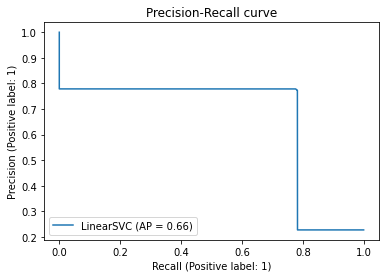

In [58]:
testGene = testGenerator("data/membrane_hospital_aughand_fakeadd/test/")#cropcom、membrane_hospital_aughand_fake、membrane_hospital_aughand_ddsm、membrane_hospital_aughand_inbreast
model = usnet41()
model.load_weights("usnet4_testcrop5_iouloss.hdf5")
#model.load_weights("un/et_fake.hdf5")

#model.load_weights("C:/Users/414/Desktop/trainresult/1205.hdf5")

results = model.predict_generator(testGene,48,verbose=1)
saveResult("data/membrane_hospital_aughand_fakeadd/test/pred/",results)
from sklearn.metrics import PrecisionRecallDisplay
# predicted_list ='data/membrane_hospital/test/pred_resize'
# groundtruth_list='data/membrane_hospital/test/labelpng'
gt_path='data/membrane_hospital_aughand_fakeadd/test/labelpng'


files=sorted(os.listdir(gt_path))
print(files)
intputshape = 512
gth1 = np.zeros((48,intputshape,intputshape)).astype(int) 
for i,item in enumerate(results):
    gth = io.imread(os.path.join(gt_path,files[i]))
    gth = trans.resize(gth,(intputshape,intputshape))#512,512
    gth= np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
    gth1[i,:,:] = gth

display = PrecisionRecallDisplay.from_predictions(gth1.flatten(),results[:,:,:,0].flatten(), name="LinearSVC")
_ = display.ax_.set_title("Precision-Recall curve")

Threshold = 0.5
results = np.where(results > Threshold, 1, 0)

TP = np.count_nonzero(results[:,:,:,0].flatten() * gth1.flatten())
TN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * (gth1.flatten() - 1))
FP = np.count_nonzero(results[:,:,:,0].flatten() * (gth1.flatten() - 1))
FN = np.count_nonzero((results[:,:,:,0].flatten() - 1) * gth1.flatten())    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
DSC = 2* TP / (FP + 2 * TP+ FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FP + TN + FN)
IoU=TP/(TP+FP+FN)
print("Precision=",precision, "Recall=",recall,"Sensitivity=" ,Sensitivity,"Specificity=",Specificity,"IoU=",IoU, "acc=",accuracy,"DSC=",DSC, "F1=",f1)

In [ ]:
gt_path='data/membrane_hospital_aughand/test/labelpng'
# evalResult(gt_path,results)
AP = PR_Result(gt_path,results)

import matplotlib
matplotlib.use("Agg")
import numpy as np
import matplotlib.pyplot as plt
plt.figure(1) # 建立圖表1
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')

#x、y都是列表，裡面存的分別是recall和precision
#傳參得到或讀取檔案得到無所謂
x=[]
y=[]
#f=open('eval.txt','r')
#lines=f.readlines()
for i in range(1, 99, 1):
    y.append(AP[i])
    x.append(i)

plt.figure(1)
plt.plot(x, y)
plt.show()
plt.savefig('p-r.png')

In [55]:
def usnet41(pretrained_weights = None,num_classes = 1,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = aspp_block(x, 32)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model

In [57]:
smooth = 1.
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 
def usnet41(pretrained_weights = None,num_classes = 1,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4, training=True)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = aspp_block(pool4, 512)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    tempcon9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    newinput =  layers.concatenate([conv9,tempcon9], axis = 3)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(newinput)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_1 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv8], axis = 3)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x, mask_2 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)

    x = layers.concatenate([x,conv7], axis = 3)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_3 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.concatenate([x,conv6], axis = 3)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_4 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x, mask_5 = MaxPoolingWithIndices2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.5)(x)
    
    # decoder
    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_5])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_4])
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_3])
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_2])
    x = layers.Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = MaxUnpoolingWithIndices2D((2, 2))([x, mask_1])
    x = layers.Convolution2D(64, (3, 3), padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = aspp_block(x, 32)
    xoutputs = layers.Conv2D(num_classes, (1, 1), padding='valid',activation=relu_advanced, kernel_initializer='he_uniform')(x)
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(1, 1)(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = xoutputs)
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    import os 
    os.environ['KERAS_BACKEND']='tensorflow'
    import tensorflow.python.keras.backend as K
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coef(y_true, y_pred)
        return loss
    
    def dice_coef_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    def iou_coef_only(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return -iou
    def connectloss(y_true, y_pred):
        return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

    #model.compile(optimizer = Adam(lr = 1e-6), loss = 'binary_crossentropy', metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(loss='mse',optimizer=Adam(lr = 1e-5),metrics='metric_fun')
    model.compile(optimizer = Adam(lr = 1e-4), loss = [iou_coef_only], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_coef_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [FocalTverskyLoss], metrics = 'accuracy')
    #model.compile(optimizer = sgd(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'accuracy')binary_accuracy、dice_coef
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [dice_loss], metrics = 'binary_accuracy')
    #model.compile(optimizer = Adam(lr = 1e-6), loss = [categorical_crossentropy], metrics = 'categorical_crossentropy')
    if(pretrained_weights):
    	model= load_model(pretrained_weights)
    
    return model